In [1]:
import os
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, concatenate, Input
from tensorflow.keras.models import Model

2023-08-15 20:26:18.289453: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
from tensorflow.keras.layers import Add
def aspp_block(x, num_filters, rate_scale=1):
    x1 = Conv2D(num_filters, (3, 3), dilation_rate=(6 * rate_scale, 6 * rate_scale), padding="same")(x)
    x1 = BatchNormalization()(x1)

    x2 = Conv2D(num_filters, (3, 3), dilation_rate=(12 * rate_scale, 12 * rate_scale), padding="same")(x)
    x2 = BatchNormalization()(x2)

    x3 = Conv2D(num_filters, (3, 3), dilation_rate=(18 * rate_scale, 18 * rate_scale), padding="same")(x)
    x3 = BatchNormalization()(x3)

    x4 = Conv2D(num_filters, (3, 3), padding="same")(x)
    x4 = BatchNormalization()(x4)

    y = Add()([x1, x2, x3, x4])
    y = Conv2D(num_filters, (1, 1), padding="same")(y)
    return y

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
def build_unet(input_shape):
    inputs = Input(input_shape)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = aspp_block(pool4, 1024)
    
    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    
    down10 = concatenate([Conv2D(64, (3, 3), activation='relu', padding='same')(conv9), conv9], axis=3)
    conv10 = Conv2D(64, (3, 3), activation='relu', padding='same')(down10)
    conv10 = BatchNormalization()(conv10)
    conv10 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv10)
    conv10 = BatchNormalization()(conv10)    
    pool10 = MaxPooling2D(pool_size=(2, 2))(conv10)

    down11 = concatenate([Conv2D(128, (3, 3), activation='relu', padding='same')(pool10), conv8], axis=3)
    conv11 = Conv2D(128, (3, 3), activation='relu', padding='same')(down11)
    conv11 = BatchNormalization()(conv11)
    conv11 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv11)
    conv11 = BatchNormalization()(conv11)   
    pool11 = MaxPooling2D(pool_size=(2, 2))(conv11)
    
    down12 = concatenate([Conv2D(256, (3, 3), activation='relu', padding='same')(pool11), conv7], axis=3)
    conv12 = Conv2D(256, (3, 3), activation='relu', padding='same')(down12)
    conv12 = BatchNormalization()(conv12)
    conv12 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv12)    
    conv12 = BatchNormalization()(conv12)
    pool12 = MaxPooling2D(pool_size=(2, 2))(conv12)

    down13 = concatenate([Conv2D(512, (3, 3), activation='relu', padding='same')(pool12), conv6], axis=3)
    conv13 = Conv2D(512, (3, 3), activation='relu', padding='same')(down13)
    conv13 = BatchNormalization()(conv13)
    conv13 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv13)  
    conv13 = BatchNormalization()(conv13)    
    pool13 = MaxPooling2D(pool_size=(2, 2))(conv13)
    
    conv14 = aspp_block(pool13, 1024)
    
    up15 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv14), conv13], axis=3)
    conv15 = Conv2D(512, (3, 3), activation='relu', padding='same')(up15)
    conv15 = BatchNormalization()(conv15)    
    conv15 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv15)
    conv15 = BatchNormalization()(conv15) 
    
    up16 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv15), conv12], axis=3)
    conv16 = Conv2D(256, (3, 3), activation='relu', padding='same')(up16)
    conv16 = BatchNormalization()(conv16)     
    conv16 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv16)
    conv16 = BatchNormalization()(conv16)      

    up17 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv16), conv11], axis=3)
    conv17 = Conv2D(128, (3, 3), activation='relu', padding='same')(up17)
    conv17 = BatchNormalization()(conv17)      
    conv17 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv17)
    conv17 = BatchNormalization()(conv17)  
    
    up18 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv17), conv10], axis=3)
    conv18 = Conv2D(64, (3, 3), activation='relu', padding='same')(up18)
    conv18 = BatchNormalization()(conv18)      
    conv18 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv18)
    conv18 = BatchNormalization()(conv18)    
    
    conv18 = aspp_block(conv18, 64)
        
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv18)
    
    model = Model(inputs, outputs, name="UNET")
    return model


In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
if __name__ == "__main__":
    input_shape = (256, 256, 3)
    model = build_unet(input_shape)
    model.summary()

2023-08-15 20:26:22.568840: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-08-15 20:26:22.569956: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-08-15 20:26:22.732116: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:0a:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-08-15 20:26:22.732143: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-08-15 20:26:22.733830: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-08-15 20:26:22.733862: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

Model: "UNET"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       batch_normalization[0][0]        
_______________________________________________________________________________________________

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K

In [6]:
""" Global parameters """
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
H = 256
W = 256
smooth = 1.

In [7]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [8]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
def load_dataset(path, split=0.2):
    images = sorted(glob(os.path.join(path, "images", "*.png")))
    masks = sorted(glob(os.path.join(path, "masks", "*.png")))

    split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [9]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (h, w)
    x = cv2.resize(x, (W, H))   ## (h, w)
    x = x / 255.0               ## (h, w)
    x = x.astype(np.float32)    ## (h, w)
    x = np.expand_dims(x, axis=-1)## (h, w, 1)
    return x

In [10]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y


def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset


In [11]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
augmentation_args = dict(
    rotation_range=0.2,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

image_datagen = ImageDataGenerator(**augmentation_args)
mask_datagen = ImageDataGenerator(**augmentation_args)


In [12]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
def read_and_augment_image(image_path):
    image = read_image(image_path)
    augmented_image = image_datagen.random_transform(image)
    return augmented_image

def read_and_augment_mask(mask_path):
    mask = read_mask(mask_path)
    augmented_mask = mask_datagen.random_transform(mask)
    return augmented_mask

def tf_parse_augmented(x, y):
    def _parse_augmented(x, y):
        x = read_and_augment_image(x)
        y = read_and_augment_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse_augmented, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset_augmented(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse_augmented)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset


In [13]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def loss(y_true, y_pred):
    return -(0.4*dice_coef(y_true, y_pred)+0.6*iou_coef(y_true, y_pred))

In [14]:
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
# config.log_device_placement = True
# sess = tf.compat.v1.Session(config=config)

# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.6  # 0.6 sometimes works better for folks
# keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("files")

    """ Hyperparameters """
    batch_size = 16
    lr = 1e-4
    num_epochs = 500
    model_path = os.path.join("files", "model2.h5")
    csv_path = os.path.join("files", "log2.csv")

    """ Dataset """
    dataset_path = "/home/akshatt/nandan/dataset/dataset/archive/"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Valid: {len(valid_x)} - {len(valid_y)}")
    print(f"Test : {len(test_x)} - {len(test_y)}")
    
    train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
#     valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)
    
#     train_dataset = tf_dataset_augmented(train_x, train_y, batch=batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

    """ Model """
    model = build_unet((H, W, 3))
    model.compile(loss=loss, optimizer=Adam(lr), metrics=[dice_coef, iou_coef])

    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
    ]

    history = model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        callbacks=callbacks
    )


Train: 1840 - 1840
Valid: 612 - 612
Test : 612 - 612


2023-08-15 20:26:39.641852: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-08-15 20:26:39.661249: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2195045000 Hz


Epoch 1/500


2023-08-15 20:26:44.056978: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-08-15 20:26:45.136781: W tensorflow/stream_executor/gpu/asm_compiler.cc:98] *** WARNING *** You are using ptxas 9.1.108, which is older than 9.2.88. ptxas 9.x before 9.2.88 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You do not need to update to CUDA 9.2.88; cherry-picking the ptxas binary is sufficient.
2023-08-15 20:26:45.263241: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


115/115 [==============================] - 116s 920ms/step - loss: -0.1222 - dice_coef: 0.1487 - iou_coef: 0.1046 - val_loss: -0.0011 - val_dice_coef: 7.7162e-05 - val_iou_coef: 0.0018

Epoch 00001: val_loss improved from inf to -0.00110, saving model to files/model2.h5
Epoch 2/500
115/115 [==============================] - 104s 905ms/step - loss: -0.4073 - dice_coef: 0.4469 - iou_coef: 0.3810 - val_loss: -0.0011 - val_dice_coef: 6.8218e-05 - val_iou_coef: 0.0018

Epoch 00002: val_loss did not improve from -0.00110
Epoch 3/500
115/115 [==============================] - 104s 905ms/step - loss: -0.4980 - dice_coef: 0.5667 - iou_coef: 0.4522 - val_loss: -0.0010 - val_dice_coef: 6.1247e-05 - val_iou_coef: 0.0017

Epoch 00003: val_loss did not improve from -0.00110
Epoch 4/500
115/115 [==============================] - 104s 905ms/step - loss: -0.5641 - dice_coef: 0.6317 - iou_coef: 0.5191 - val_loss: -0.0183 - val_dice_coef: 0.0236 - val_iou_coef: 0.0147

Epoch 00004: val_loss improved from

Epoch 32/500
115/115 [==============================] - 104s 906ms/step - loss: -0.8286 - dice_coef: 0.8824 - iou_coef: 0.7927 - val_loss: -0.7417 - val_dice_coef: 0.8077 - val_iou_coef: 0.6977

Epoch 00032: val_loss improved from -0.73550 to -0.74167, saving model to files/model2.h5
Epoch 33/500
115/115 [==============================] - 104s 906ms/step - loss: -0.8343 - dice_coef: 0.8873 - iou_coef: 0.7990 - val_loss: -0.7464 - val_dice_coef: 0.8134 - val_iou_coef: 0.7018

Epoch 00033: val_loss improved from -0.74167 to -0.74640, saving model to files/model2.h5
Epoch 34/500
115/115 [==============================] - 104s 906ms/step - loss: -0.8388 - dice_coef: 0.8909 - iou_coef: 0.8041 - val_loss: -0.7491 - val_dice_coef: 0.8131 - val_iou_coef: 0.7065

Epoch 00034: val_loss improved from -0.74640 to -0.74915, saving model to files/model2.h5
Epoch 35/500
115/115 [==============================] - 104s 906ms/step - loss: -0.8400 - dice_coef: 0.8911 - iou_coef: 0.8058 - val_loss: -0.753

115/115 [==============================] - 104s 905ms/step - loss: -0.8605 - dice_coef: 0.9071 - iou_coef: 0.8295 - val_loss: -0.7571 - val_dice_coef: 0.8224 - val_iou_coef: 0.7131

Epoch 00063: val_loss did not improve from -0.75719
Epoch 64/500
115/115 [==============================] - 104s 906ms/step - loss: -0.8606 - dice_coef: 0.9071 - iou_coef: 0.8295 - val_loss: -0.7571 - val_dice_coef: 0.8224 - val_iou_coef: 0.7131

Epoch 00064: val_loss did not improve from -0.75719

Epoch 00064: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 65/500
115/115 [==============================] - 104s 906ms/step - loss: -0.8606 - dice_coef: 0.9071 - iou_coef: 0.8296 - val_loss: -0.7571 - val_dice_coef: 0.8224 - val_iou_coef: 0.7131

Epoch 00065: val_loss did not improve from -0.75719


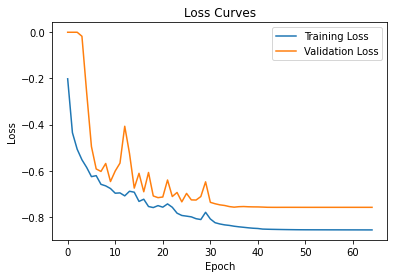

In [15]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


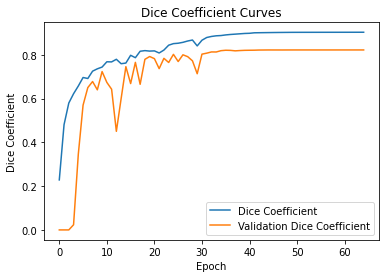

In [16]:
plt.plot(history.history['dice_coef'], label='Dice Coefficient')
plt.plot(history.history['val_dice_coef'], label='Validation Dice Coefficient')
plt.title('Dice Coefficient Curves')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()


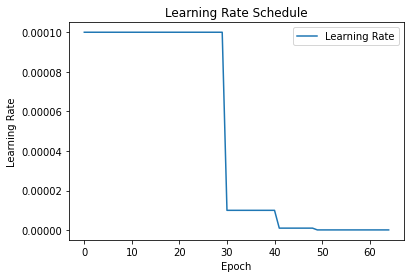

In [17]:
plt.plot(history.history['lr'], label='Learning Rate')
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()
plt.show()


In [18]:
from tqdm import tqdm
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score

In [19]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"


""" Creating a directory """

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def save_results(image, mask, y_pred, save_image_path):
    mask = np.expand_dims(mask, axis=-1)
    mask = np.concatenate([mask, mask, mask], axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)
    y_pred = y_pred * 255

    line = np.ones((H, 10, 3)) * 255

    cat_images = np.concatenate([image, line, mask, line, y_pred], axis=1)
    cv2.imwrite(save_image_path, cat_images)

In [20]:
import pandas as pd
if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("results")

    """ Load the model """
    with CustomObjectScope({'loss': loss, 'dice_coef': dice_coef, 'iou_coef': iou_coef}):
        model = tf.keras.models.load_model(os.path.join("files", "model2.h5"))

    """ Dataset """
    dataset_path = "/home/akshatt/nandan/dataset/dataset/archive/"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

    """ Prediction and Evaluation """
    SCORE = []
    for x, y in tqdm(zip(test_x, test_y), total=len(test_y)):
        """ Extracting the name """
        name = x.split("/")[-1]

        """ Reading the image """
        image = cv2.imread(x, cv2.IMREAD_COLOR) ## [H, w, 3]
        image = cv2.resize(image, (W, H))       ## [H, w, 3]
        x = image/255.0                         ## [H, w, 3]
        x = np.expand_dims(x, axis=0)           ## [1, H, w, 3]

        """ Reading the mask """
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (W, H))

        """ Prediction """
        y_pred = model.predict(x, verbose=0)[0]
        y_pred = np.squeeze(y_pred, axis=-1)
        y_pred = y_pred >= 0.5
        y_pred = y_pred.astype(np.int32)

        """ Saving the prediction """
        save_image_path = os.path.join("results2", name)
        save_results(image, mask, y_pred, save_image_path)

        """ Flatten the array """
        mask = mask/255.0
        mask = (mask > 0.5).astype(np.int32).flatten()
        y_pred = y_pred.flatten()

        """ Calculating the metrics values """
        f1_value = f1_score(mask, y_pred, labels=[0, 1], average="binary")
        jac_value = jaccard_score(mask, y_pred, labels=[0, 1], average="binary")
        recall_value = recall_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
        precision_value = precision_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
        y_pred = y_pred.astype(np.float32)
        mask = mask.astype(np.float32).flatten()
        dice_value = dice_coef(mask, y_pred)
        SCORE.append([name, f1_value, jac_value, recall_value, precision_value, dice_value])

    """ Metrics values """
    score = [s[1:]for s in SCORE]
    score = np.mean(score, axis=0)
    print(f"F1: {score[0]:0.5f}")
    print(f"Jaccard: {score[1]:0.5f}")
    print(f"Recall: {score[2]:0.5f}")
    print(f"Precision: {score[3]:0.5f}")
    print(f"dice_value: {score[4]:0.5f}")

    df = pd.DataFrame(SCORE, columns=["Image", "F1", "Jaccard", "Recall", "Precision", "Dice_value"])
    df.to_csv("files/score2.csv")


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 612/612 [01:02<00:00,  9.84it/s]

F1: 0.79097
Jaccard: 0.70422
Recall: 0.79349
Precision: 0.82851
dice_value: 0.79126
